# Factor Graph Algorithms: Max-Sum, GDP, GD2P, and FDSP

This notebook demonstrates four different algorithms for solving factor graphs:
1. **Max-Sum**: Basic message passing algorithm
2. **GDP**: Generalized Distributive Pruning
3. **GD2P**: Generalized Distributive 2-Pruning
4. **FDSP**: Function Decomposition and State Pruning

All algorithms solve the same optimization problem but use different pruning strategies to improve efficiency, with FDSP providing the most sophisticated function decomposition approach.

## Necessary Imports

In [67]:
# Import required libraries
import itertools
import copy
import time
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from typing import Literal

# Utility function to create utility tables
def make_util_table(var_order, rows):
    """Convert list of value tuples and scores to utility table dictionary"""
    return {tuple(row[:-1]): row[-1] for row in rows}

## Class for Factor Graph


In [68]:
class DCOPProblem:
    """
    Data structure to represent a Distributed Constraint Optimization Problem (DCOP).
    """
    def __init__(self):
        self.variables = {}  # variable_name -> domain (list of values)
        self.functions = []  # list of (scope, utility_table) tuples
        
    def add_variable(self, name, domain):
        """Add a variable with its domain."""
        self.variables[name] = domain
        
    def add_function(self, scope, utility_table):
        """Add a function with its scope (list of variable names) and utility table (numpy array)."""
        self.functions.append((scope, utility_table))
        
    def get_summary(self):
        """Get a summary of the problem."""
        num_vars = len(self.variables)
        num_funcs = len(self.functions)
        total_domain_size = sum(len(domain) for domain in self.variables.values())
        avg_domain_size = total_domain_size / num_vars if num_vars > 0 else 0
        
        arities = [len(scope) for scope, _ in self.functions]
        avg_arity = sum(arities) / len(arities) if arities else 0
        
        return {
            'num_variables': num_vars,
            'num_functions': num_funcs,
            'avg_domain_size': avg_domain_size,
            'avg_arity': avg_arity,
            'min_arity': min(arities) if arities else 0,
            'max_arity': max(arities) if arities else 0
        }

def generate_DCOP_problem(
    graph_type: Literal['sparse', 'dense'],
    arity_type: Literal['low', 'high'],
    domain_size_type: Literal['small', 'large'],
    num_functions: int    
) -> DCOPProblem:
    """
    Generate a random DCOP problem with specified characteristics.
    """
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # 1) Variable threshold based on graph density
    if graph_type == 'sparse':
        vt_low, vt_high = 0.1, 0.5
    else:
        vt_low, vt_high = 0.5, 0.9
    var_T = np.random.uniform(vt_low, vt_high)

    # 2) Arity bounds
    if arity_type == 'low':
        a_low, a_high = 2, 6
    else:
        a_low, a_high = 6, 10

    # 3) Domain-size bounds
    if domain_size_type == 'small':
        d_low, d_high = 2, 6
    else:
        d_low, d_high = 6, 10

    # 4) Sample arities for each function
    arities = np.random.randint(a_low, a_high + 1, size=num_functions)
    A_total = int(arities.sum())

    # 5) Compute number of variables from var_T = 1 - V/A_total
    V = int(round((1.0 - var_T) * A_total))
    # Ensure reasonable bounds
    V = max(V, max(arities))  # At least enough variables for largest function
    V = min(V, A_total)       # Cannot exceed total arity

    # 6) Build problem
    prob = DCOPProblem()
    
    # 7) Add variables with random domain-sizes
    var_names = []
    for i in range(V):
        dom_size = int(np.random.randint(d_low, d_high + 1))
        name = f'x{i}'
        prob.add_variable(name, list(range(dom_size)))
        var_names.append(name)

    # 8) Create constraint graph to track variable connections
    constraint_graph = nx.Graph()
    constraint_graph.add_nodes_from(var_names)

    # 9) Add functions while ensuring no cycles
    functions_added = 0
    max_attempts = num_functions * 10  # Prevent infinite loops
    attempts = 0

    while functions_added < num_functions and attempts < max_attempts:
        attempts += 1
        k = arities[functions_added]

        # Try to find a valid scope that doesn't create cycles
        scope_found = False
        max_scope_attempts = 50

        for _ in range(max_scope_attempts):
            # Choose k distinct variables
            if k > len(var_names):
                k = len(var_names)  # Adjust if too many variables requested
                
            candidate_scope = list(np.random.choice(var_names, size=k, replace=False))

            # Check if adding edges between all pairs in this scope creates a cycle
            temp_graph = constraint_graph.copy()
            edges_to_add = []

            # For each pair of variables in the scope, add an edge
            for i in range(len(candidate_scope)):
                for j in range(i + 1, len(candidate_scope)):
                    var1, var2 = candidate_scope[i], candidate_scope[j]
                    if not temp_graph.has_edge(var1, var2):
                        edges_to_add.append((var1, var2))

            # Add all edges and check for cycles
            temp_graph.add_edges_from(edges_to_add)

            if nx.is_forest(temp_graph):  # No cycles
                # Accept this scope
                constraint_graph.add_edges_from(edges_to_add)
                scope_found = True
                break

        if scope_found:
            # Create the function with this scope
            dims = [len(prob.variables[v]) for v in candidate_scope]
            # Generate random utility values between 1 and 10
            table = np.random.randint(1, 11, size=tuple(dims))
            prob.add_function(candidate_scope, table)
            functions_added += 1
        else:
            # If we can't find a valid scope, try with a smaller arity
            if k > 2:
                arities[functions_added] = max(2, k - 1)
            else:
                # Skip this function if we can't even do arity 2
                functions_added += 1

    if functions_added < num_functions:
        print(f"Warning: Could only add {functions_added} out of {num_functions} functions while maintaining acyclic structure")

    return prob



## Factor Graph Configuration Parameters

This section defines the structure of the factor graph for our DCOP (Distributed Constraint Optimization Problem) experiments. The factor graph structure is determined by four key parameters:

### Core Parameters

1. **Graph Type**
    - `sparse`: Fewer connections between variables and functions (var_T between 0.1-0.5)
    - `dense`: More connections between variables and functions (var_T between 0.5-0.9)

2. **Arity Type**
    - `low`: Functions depend on fewer variables (arity between 2-6)
    - `high`: Functions depend on more variables (arity between 6-10)

3. **Domain Size Type**
    - `small`: Variables can take fewer values (domain size between 2-6)
    - `large`: Variables can take more values (domain size between 6-10)

4. **Number of Functions**
    - Controls how many constraint functions are created in the problem

### Impact on Algorithm Performance

- **Sparse + Low Arity + Small Domain**: Easiest to solve, best for testing basic functionality
- **Dense + High Arity + Large Domain**: Most challenging, best for testing algorithm efficiency
- **Mixed configurations**: Allow testing specific aspects of algorithm performance

The configuration determines the computational complexity and scalability challenges that each algorithm (Max-Sum, GDP, GD2P) must overcome.


In [69]:

# Configuration for DCOP type
configs = {
    "graph_type": "dense", # sparse or dense
    "arity_type": "low",     # low or high arity
    "domain_size_type": "small", # small or large domain sizes
    "num_functions": 25      # Number of functions to generate
}
# Configuration options
print(f"\nSelected configuration for DCOP generation:")
print(f"- Graph type: {configs['graph_type']}")
print(f"- Arity type: {configs['arity_type']}")
print(f"- Domain size type: {configs['domain_size_type']}")

# Generate the DCOP problem
dcop_problem = generate_DCOP_problem(
    graph_type=configs['graph_type'],
    arity_type=configs['arity_type'], 
    domain_size_type=configs['domain_size_type'],
    num_functions=configs['num_functions']
)

# Display problem summary
summary = dcop_problem.get_summary()
print(f"\nGenerated Problem Summary:")
print(f"- Variables: {summary['num_variables']}")
print(f"- Functions: {summary['num_functions']}")
print(f"- Average domain size: {summary['avg_domain_size']:.1f}")
print(f"- Average arity: {summary['avg_arity']:.1f}")
print(f"- Arity range: {summary['min_arity']} - {summary['max_arity']}")

print()
print()

print("="*80)
print("VARIABLE DETAILS")
print("="*80)
for var_name, domain in list(dcop_problem.variables.items()):
    print(f"  {var_name}: domain size {len(domain)} (values: {domain})")

print()
print()

# Display Function Utility Tables in Tabular Format
print("="*80)
print("FUNCTION UTILITY TABLES")
print("="*80)

for i, (scope, utility_table) in enumerate(dcop_problem.functions):
    func_name = f'F{i+1}'
    print(f"\n{func_name}: {scope}")
    print("-" * 60)
    
    # Get variable domains for this function
    var_domains = [dcop_problem.variables[var] for var in scope]
    
    # Create header
    header = ""
    for var in scope:
        header += f"{var:<8}"
    header += "Utility"
    print(header)
    print("-" * len(header))
    
    # Print all combinations and their utilities
    for indices in itertools.product(*[range(len(domain)) for domain in var_domains]):
        # Print variable values
        row = ""
        for j, var in enumerate(scope):
            actual_value = dcop_problem.variables[var][indices[j]]
            row += f"{actual_value:<8}"
        
        # Print utility value
        utility_value = utility_table[indices]
        row += f"{utility_value}"
        print(row)
    
    print()  # Empty line between functions


Selected configuration for DCOP generation:
- Graph type: dense
- Arity type: low
- Domain size type: small

Generated Problem Summary:
- Variables: 38
- Functions: 25
- Average domain size: 4.1
- Average arity: 2.0
- Arity range: 2 - 2


VARIABLE DETAILS
  x0: domain size 4 (values: [0, 1, 2, 3])
  x1: domain size 3 (values: [0, 1, 2])
  x2: domain size 5 (values: [0, 1, 2, 3, 4])
  x3: domain size 5 (values: [0, 1, 2, 3, 4])
  x4: domain size 4 (values: [0, 1, 2, 3])
  x5: domain size 5 (values: [0, 1, 2, 3, 4])
  x6: domain size 5 (values: [0, 1, 2, 3, 4])
  x7: domain size 2 (values: [0, 1])
  x8: domain size 4 (values: [0, 1, 2, 3])
  x9: domain size 6 (values: [0, 1, 2, 3, 4, 5])
  x10: domain size 4 (values: [0, 1, 2, 3])
  x11: domain size 6 (values: [0, 1, 2, 3, 4, 5])
  x12: domain size 2 (values: [0, 1])
  x13: domain size 3 (values: [0, 1, 2])
  x14: domain size 5 (values: [0, 1, 2, 3, 4])
  x15: domain size 2 (values: [0, 1])
  x16: domain size 5 (values: [0, 1, 2, 3, 4])

## Drawing the Factor Graph

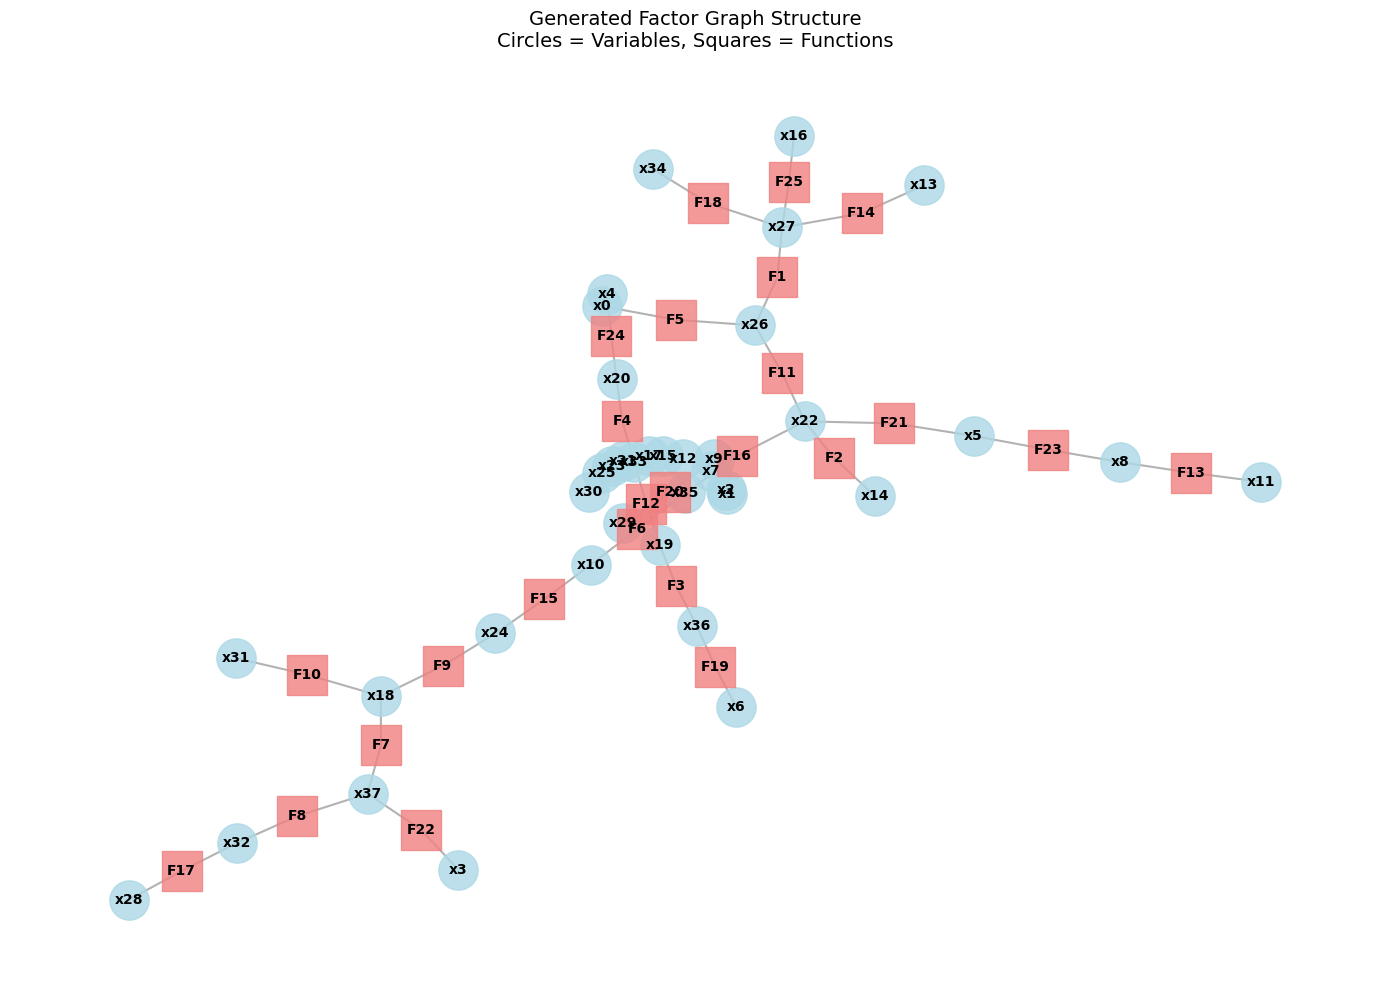

Factor Graph Connections:
F1 connects: x27(|D|=6), x26(|D|=5)
F2 connects: x14(|D|=5), x22(|D|=3)
F3 connects: x19(|D|=2), x36(|D|=6)
F4 connects: x33(|D|=3), x20(|D|=3)
F5 connects: x26(|D|=5), x0(|D|=4)
F6 connects: x35(|D|=5), x10(|D|=4)
F7 connects: x37(|D|=3), x18(|D|=3)
F8 connects: x32(|D|=5), x37(|D|=3)
F9 connects: x24(|D|=5), x18(|D|=3)
F10 connects: x31(|D|=3), x18(|D|=3)
F11 connects: x22(|D|=3), x26(|D|=5)
F12 connects: x33(|D|=3), x19(|D|=2)
F13 connects: x8(|D|=4), x11(|D|=6)
F14 connects: x13(|D|=3), x27(|D|=6)
F15 connects: x10(|D|=4), x24(|D|=5)
F16 connects: x22(|D|=3), x35(|D|=5)
F17 connects: x32(|D|=5), x28(|D|=4)
F18 connects: x34(|D|=3), x27(|D|=6)
F19 connects: x36(|D|=6), x6(|D|=5)
F20 connects: x29(|D|=2), x9(|D|=6)
F21 connects: x22(|D|=3), x5(|D|=5)
F22 connects: x3(|D|=5), x37(|D|=3)
F23 connects: x5(|D|=5), x8(|D|=4)
F24 connects: x4(|D|=4), x20(|D|=3)
F25 connects: x16(|D|=5), x27(|D|=6)

Graph Statistics:
- Total nodes: 63 (38 variables + 25 functions)


In [70]:
def draw_factor_graph(dcop_problem):
    """
    Draw the factor graph visualization for the generated DCOP problem showing:
    - Circular nodes for variables
    - Square nodes for function nodes
    - Edges connecting variables to their functions
    """
    # Create networkx graph
    G = nx.Graph()
    
    # Add variable nodes (circular)
    variables = list(dcop_problem.variables.keys())
    for var in variables:
        G.add_node(var, node_type='variable')
    
    # Add function nodes (square) and edges
    function_names = []
    for i, (scope, _) in enumerate(dcop_problem.functions):
        func_name = f'F{i+1}'
        function_names.append(func_name)
        G.add_node(func_name, node_type='function')
        
        # Add edges between function and its variables
        for var in scope:
            G.add_edge(var, func_name)
    
    # Create layout - try different layouts for better visualization
    if len(variables) <= 10:
        pos = nx.spring_layout(G, k=3, iterations=50, seed=42)
    else:
        pos = nx.kamada_kawai_layout(G)
    
    # Create the plot
    plt.figure(figsize=(14, 10))
    
    # Draw variable nodes (circles)
    var_nodes = [n for n in G.nodes() if n.startswith('x')]
    nx.draw_networkx_nodes(G, pos, nodelist=var_nodes, node_color='lightblue', 
                          node_shape='o', node_size=800, alpha=0.8)
    
    # Draw function nodes (squares)
    func_nodes = [n for n in G.nodes() if n.startswith('F')]
    nx.draw_networkx_nodes(G, pos, nodelist=func_nodes, node_color='lightcoral', 
                          node_shape='s', node_size=800, alpha=0.8)
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=1.5, alpha=0.6)
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    
    plt.title("Generated Factor Graph Structure\nCircles = Variables, Squares = Functions", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print connections
    print("Factor Graph Connections:")    
    for i, (scope, _) in enumerate(dcop_problem.functions):
        func_name = f'F{i+1}'
        var_info = []
        for var in scope:
            domain_size = len(dcop_problem.variables[var])
            var_info.append(f"{var}(|D|={domain_size})")
        print(f"{func_name} connects: {', '.join(var_info)}")
    
    # Print graph statistics
    print(f"\nGraph Statistics:")
    print(f"- Total nodes: {G.number_of_nodes()} ({len(var_nodes)} variables + {len(func_nodes)} functions)")
    print(f"- Total edges: {G.number_of_edges()}")
    print(f"- Graph density: {nx.density(G):.3f}")
    print(f"- Is connected: {nx.is_connected(G)}")
    if nx.is_connected(G):
        print(f"- Average path length: {nx.average_shortest_path_length(G):.2f}")

# Draw the generated factor graph
draw_factor_graph(dcop_problem)

## Class For VariableNode

In [71]:
class VariableNode:
    """
    Variable node in the factor graph.
    Same implementation for all algorithms (Max-Sum, GDP, GD2P).
    """
    def __init__(self, name, domain):
        self.name = name
        self.domain = domain
        self.neighbors = []  # Connected function nodes
        self.incoming = {}   # Messages from function nodes
        self.outgoing = {}   # Messages to function nodes

    def send_message(self, fnode):
        """
        Send message from variable to function node.
        Message contains utility for each value in domain.
        """
        message = {}
        for xi in self.domain:
            # Sum all incoming messages from other function nodes
            s = 0
            for n in self.neighbors:
                if n is not fnode:  # Exclude the target function node
                    s += self.incoming.get(n, {}).get(xi, 0)
            message[xi] = s
        self.outgoing[fnode] = message

    def best_value(self):
        """
        Determine the best value for this variable based on all incoming messages.
        Returns the best value and the scores for all values.
        """
        z = {}
        for xi in self.domain:
            # Sum all incoming messages from all function nodes
            total = sum(self.incoming.get(fnode, {}).get(xi, 0) for fnode in self.neighbors)
            z[xi] = total
        
        # Find the value with maximum score
        best = max(sorted(z), key=lambda x: z[x])
        return best, z


## Class For FunctionNode

In [72]:
class FunctionNode:
    """
    Function node in the factor graph.
    Contains different message passing methods for different algorithms.
    """
    def __init__(self, name, variables, utility_table):
        self.name = name
        self.variables = variables    # List of variable node names
        self.utility_table = utility_table  # Dict: (tuple of values) -> utility
        self.neighbors = []           # Variable node objects
        self.incoming = {}            # Messages from variable nodes
        self.outgoing = {}            # Messages to variable nodes
        
        # For GDP and GD2P algorithms
        self.sorted_assignments = {}  # For GDP
        self.SortedEntries = {}      # For GD2P

        # For FDSP algorithm
        self.uninformed_est = {}      # {var: {partial_assignment: max_utility}}
        self.informed_est = {}        # {(var_i, var_j, val_j): {partial: max_utility}}
        self.lb = float('-inf')       # Lower bound for FDSP pruning

        # Pruning statistics for all algorithms
        self.prune_stats = {}         # {algorithm: {'total': total_evaluations, 'pruned': pruned_evaluations}}

    def setup_domains(self):
        """
        Precompute sorted assignments for GDP and GD2P pruning.
        Should be called ONCE after neighbors are assigned!
        """
        # Initialize pruning statistics
        self.prune_stats = {
            'gdp': {'total': 0, 'pruned': 0},
            'gd2p': {'total': 0, 'pruned': 0},
            'fdsp': {'total': 0, 'pruned': 0}
        }
        
        # For GDP pruning
        self.sorted_assignments = {}
        for idx, v in enumerate(self.neighbors):
            val2assigns = {}
            for xi in v.domain:
                matching = []
                for assign, util in self.utility_table.items():
                    if assign[idx] == xi:
                        matching.append((util, assign))
                matching.sort(reverse=True)  # Sort by descending utility
                val2assigns[xi] = matching
            self.sorted_assignments[idx] = val2assigns
        
        # For GD2P pruning
        self.SortedEntries = {}
        for idx, v in enumerate(self.neighbors):
            val2sorted = {}
            for xi in v.domain:
                matching = []
                for assign, util in self.utility_table.items():
                    if assign[idx] == xi:
                        matching.append((util, assign))
                matching.sort(reverse=True)
                val2sorted[xi] = [t[1] for t in matching]  # Only assignments, not utilities
            self.SortedEntries[idx] = val2sorted

        # For FDSP algorithm - precompute estimations
        self.compute_fdsp_estimations()

    def compute_fdsp_estimations(self):
        """
        Precompute uninformed and informed estimates for FDSP algorithm.
        """
        # Initialize estimation dictionaries
        self.uninformed_est = {var: {} for var in self.variables}
        self.informed_est = {}

        # Step 1: Precompute uninformed estimates (Eq. 5)
        for i in reversed(range(len(self.variables))):
            var = self.variables[i]
            for assignment in itertools.product(*(v.domain for v in self.neighbors)):
                partial = assignment[:i+1]
                max_val = max(
                    self.utility_table[a] for a in self.utility_table if a[:i+1] == partial
                )
                self.uninformed_est[var][partial] = max_val

        # Step 2: Precompute informed estimates (Eq. 6)
        for j in range(len(self.variables)):
            var_j = self.variables[j]
            for val_j in self.neighbors[j].domain:
                for i in range(j):
                    var_i = self.variables[i]
                    key = (var_i, var_j, val_j)
                    self.informed_est[key] = {}
                    for partial in itertools.product(*(v.domain for v in self.neighbors[:i+1])):
                        filtered = [
                            a for a in self.utility_table if a[j] == val_j and a[:i+1] == partial
                        ]
                        if filtered:
                            self.informed_est[key][partial] = max(self.utility_table[a] for a in filtered)

    # MAX-SUM Algorithm (basic message passing)
    def send_message(self, varnode):
        """
        Basic Max-Sum message passing (no pruning).
        """
        idx = self.variables.index(varnode.name)
        domains = [v.domain for v in self.neighbors]
        message = {}
        
        for xi in varnode.domain:
            best = float("-inf")
            # Consider all possible assignments
            for assign in itertools.product(*domains):
                if assign[idx] != xi:
                    continue
                
                u = self.utility_table[assign]
                s = 0
                for k, v in enumerate(self.neighbors):
                    if v is varnode:
                        continue
                    qmsg = v.outgoing[self]
                    s += qmsg[assign[k]]
                total = u + s
                best = max(best, total)
            message[xi] = best
        self.outgoing[varnode] = message

    # GDP Algorithm (Generalized Distributive Pruning)
    def gdp_prune(self, var_idx, varnode):
        """
        GDP pruning strategy to reduce search space.
        """
        pruned_ranges = {}
        for xi in varnode.domain:
            assignments = self.sorted_assignments[var_idx][xi]
            if not assignments:
                continue
            
            total_assignments = len(assignments)
            
            Vi = [t[0] for t in assignments]    # Utilities, descending
            p = Vi[0]  # Maximum utility
            
            # m: sum max from all incoming (except receiving variable)
            m = 0
            for k, v in enumerate(self.neighbors):
                if k == var_idx:
                    continue
                qmsg = v.outgoing[self]
                m += max(qmsg.values())
            
            # b: sum of actual incoming for max utility assignment (p)
            b = 0
            for k, v in enumerate(self.neighbors):
                if k == var_idx:
                    continue
                qmsg = v.outgoing[self]
                b += qmsg[assignments[0][1][k]]
            
            t = m - b
            target = p - t
            
            # Find in sorted Vi the largest index i so that Vi[i] <= target
            qidx = None
            for i, val in enumerate(Vi):
                if val <= target:
                    qidx = i
                    break
            if qidx is None:  # All Vi > target
                qidx = len(Vi) - 1
            q = Vi[qidx]
            
            # Indices [q, p] (i.e., those for which q <= val <= p)
            idxs = [i for i, val in enumerate(Vi) if q <= val <= p]
            pruned_ranges[xi] = [assignments[i][1] for i in idxs]
            
            # Update pruning statistics
            used_assignments = len(idxs)
            self.prune_stats['gdp']['total'] += total_assignments
            self.prune_stats['gdp']['pruned'] += (total_assignments - used_assignments)
        
        return pruned_ranges

    def send_message_gdp(self, varnode):
        """
        GDP message passing with pruning.
        """
        idx = self.variables.index(varnode.name)
        pruned_ranges = self.gdp_prune(idx, varnode)
        message = {}
        
        for xi in varnode.domain:
            best = float("-inf")
            # Only maximize over GDP-pruned assignments for xi
            relevant_assigns = pruned_ranges.get(xi, [])
            for assign in relevant_assigns:
                u = self.utility_table[assign]
                s = 0
                for i, v in enumerate(self.neighbors):
                    if i == idx:
                        continue
                    qmsg = v.outgoing[self]
                    s += qmsg[assign[i]]
                total = u + s
                if total > best:
                    best = total
            message[xi] = best
        self.outgoing[varnode] = message

    # GD2P Algorithm (Generalized Distributive 2-Pruning)
    def send_message_gd2p(self, varnode):
        """
        GD2P message passing with enhanced pruning.
        """
        idx = self.variables.index(varnode.name)
        
        # Step 1: msgUB = sum_k [max incoming message from each neighbor except varnode]
        msgUB = 0
        for k, v in enumerate(self.neighbors):
            if k == idx:
                continue
            qmsg = v.outgoing[self]
            msgUB += max(qmsg.values())
        
        message = {}
        
        for xi in varnode.domain:
            sorted_assignments = self.SortedEntries[idx][xi]
            max_util = float("-inf")
            lb = float("-inf")
            
            total_assignments = len(sorted_assignments)
            evaluations_performed = 0

            for assignment in sorted_assignments:
                util = self.utility_table[assignment]
                if util < lb:
                    break  # Pruning: skip remaining assignments

                evaluations_performed += 1
                sum_q = 0
                for k, v in enumerate(self.neighbors):
                    if k == idx:
                        continue
                    qmsg = v.outgoing[self]
                    sum_q += qmsg[assignment[k]]
                
                u = util + sum_q
                max_util = max(max_util, u)
                lb = max_util - msgUB  # Update lower bound
            
            # Update pruning statistics
            self.prune_stats['gd2p']['total'] += total_assignments
            self.prune_stats['gd2p']['pruned'] += (total_assignments - evaluations_performed)
            
            message[xi] = max_util
        self.outgoing[varnode] = message

    # FDSP Algorithm (Function Decomposition and State Pruning)
    def send_message_fdsp(self, varnode):
        """
        FDSP message passing with function decomposition and state pruning.
        """
        idx_target = self.variables.index(varnode.name)
        domains = [v.domain for v in self.neighbors]
        message = {}

        for val_target in varnode.domain:
            assignment = [None] * len(self.variables)
            assignment[idx_target] = val_target
            self.lb = float('-inf')  # Reset lower bound for each value
            
            # Reset FDSP evaluation counters
            self.fdsp_total_nodes = 0
            self.fdsp_pruned_nodes = 0
            
            best_util = self._fdsp_recursive(assignment, idx=0, target_idx=idx_target, msg_util=0)
            message[val_target] = best_util
            
            # Update pruning statistics
            self.prune_stats['fdsp']['total'] += self.fdsp_total_nodes
            self.prune_stats['fdsp']['pruned'] += self.fdsp_pruned_nodes

        self.outgoing[varnode] = message

    def _fdsp_recursive(self, assignment, idx, target_idx, msg_util):
        """
        Recursive FDSP search with function decomposition and state pruning.
        """
        # Skip target variable index (already assigned)
        if idx == target_idx:
            return self._fdsp_recursive(assignment, idx + 1, target_idx, msg_util)

        # Base case: all variables assigned
        if idx >= len(self.variables):
            util = self.utility_table[tuple(assignment)] + msg_util
            self.lb = max(self.lb, util)
            return util

        var = self.neighbors[idx]
        best = float('-inf')
        
        for val in var.domain:
            self.fdsp_total_nodes += 1
            
            assignment[idx] = val
            q_msg = var.outgoing[self][val]
            msg_total = msg_util + q_msg

            # Compute upper bound (uninformed or informed)
            partial = tuple(assignment[:idx+1])
            if idx < target_idx:
                key = (self.variables[idx], self.variables[target_idx], assignment[target_idx])
                est = self.informed_est.get(key, {}).get(partial, float('-inf'))
            else:
                est = self.uninformed_est[self.variables[idx]].get(partial, float('-inf'))

            # Calculate message estimate for remaining variables
            msg_est = sum(max(v.outgoing[self].values()) for i, v in enumerate(self.neighbors) 
                         if i > idx and i != target_idx)

            ub = msg_total + est + msg_est

            # Prune if upper bound is not better than current lower bound
            if ub > self.lb:
                util = self._fdsp_recursive(assignment[:], idx + 1, target_idx, msg_total)
                best = max(best, util)
            else:
                self.fdsp_pruned_nodes += 1

        return best

print("FunctionNode class created with all four algorithms (Max-Sum, GDP, GD2P, FDSP)!")

FunctionNode class created with all four algorithms (Max-Sum, GDP, GD2P, FDSP)!


## Max-Sum Solver Class

In [73]:
class MaxSumSolver:
    """
    Solver for factor graphs with support for different algorithms.
    """
    def __init__(self, variable_nodes, function_nodes):
        self.variables = {v.name: v for v in variable_nodes}
        self.functions = {f.name: f for f in function_nodes}
        
        # Connect variables and functions
        for f in function_nodes:
            for v in f.variables:
                f.neighbors.append(self.variables[v])
                self.variables[v].neighbors.append(f)
        
        # Setup domains for GDP, GD2P, and FDSP algorithms
        for f in function_nodes:
            f.setup_domains()

    def _initialize_messages(self):
        """Initialize all messages to zero."""
        for v in self.variables.values():
            for f in v.neighbors:
                v.incoming[f] = {x: 0 for x in v.domain}
                v.outgoing[f] = {x: 0 for x in v.domain}
        for f in self.functions.values():
            for v in f.neighbors:
                f.incoming[v] = {x: 0 for x in v.domain}
                f.outgoing[v] = {x: 0 for x in v.domain}

    def _get_solution(self):
        """Extract solution from final messages."""
        solution = {}
        scores = {}
        for v in self.variables.values():
            best, z = v.best_value()
            solution[v.name] = best
            scores[v.name] = z
        return solution, scores

    def _get_pruning_stats(self, algorithm):
        """Get pruning statistics for a specific algorithm."""
        total_evaluations = 0
        total_pruned = 0
        
        for f in self.functions.values():
            if algorithm in f.prune_stats:
                total_evaluations += f.prune_stats[algorithm]['total']
                total_pruned += f.prune_stats[algorithm]['pruned']
        
        if total_evaluations > 0:
            pruning_percentage = (total_pruned / total_evaluations) * 100
        else:
            pruning_percentage = 0.0
            
        return pruning_percentage, total_evaluations, total_pruned

    # MAX-SUM Algorithm
    def run(self, iterations=10):
        """
        Run basic Max-Sum algorithm.
        """
        self._initialize_messages()
        
        for it in range(iterations):
            # Variable to function messages
            for v in self.variables.values():
                for f in v.neighbors:
                    v.send_message(f)
                    f.incoming[v] = copy.deepcopy(v.outgoing[f])
            
            # Function to variable messages
            for f in self.functions.values():
                for v in f.neighbors:
                    f.send_message(v)  # Basic Max-Sum
                    v.incoming[f] = copy.deepcopy(f.outgoing[v])
        
        return self._get_solution()

    # GDP Algorithm
    def run_gdp(self, iterations=10):
        """
        Run GDP (Generalized Distributive Pruning) algorithm.
        """
        self._initialize_messages()
        
        for it in range(iterations):
            # Variable to function messages
            for v in self.variables.values():
                for f in v.neighbors:
                    v.send_message(f)
                    f.incoming[v] = copy.deepcopy(v.outgoing[f])
            
            # Function to variable messages with GDP pruning
            for f in self.functions.values():
                for v in f.neighbors:
                    f.send_message_gdp(v)  # GDP pruning
                    v.incoming[f] = copy.deepcopy(f.outgoing[v])
        
        solution, scores = self._get_solution()
        pruning_percentage, total_evals, total_pruned = self._get_pruning_stats('gdp')
        return solution, scores, pruning_percentage

    # GD2P Algorithm
    def run_gd2p(self, iterations=10):
        """
        Run GD2P (Generalized Distributive 2-Pruning) algorithm.
        """
        self._initialize_messages()
        
        for it in range(iterations):
            # Variable to function messages
            for v in self.variables.values():
                for f in v.neighbors:
                    v.send_message(f)
                    f.incoming[v] = copy.deepcopy(v.outgoing[f])
            
            # Function to variable messages with GD2P pruning
            for f in self.functions.values():
                for v in f.neighbors:
                    f.send_message_gd2p(v)  # GD2P pruning
                    v.incoming[f] = copy.deepcopy(f.outgoing[v])
        
        solution, scores = self._get_solution()
        pruning_percentage, total_evals, total_pruned = self._get_pruning_stats('gd2p')
        return solution, scores, pruning_percentage

    # FDSP Algorithm
    def run_fdsp(self, iterations=10):
        """
        Run FDSP (Function Decomposition and State Pruning) algorithm.
        """
        self._initialize_messages()
        
        for it in range(iterations):
            # Variable to function messages
            for v in self.variables.values():
                for f in v.neighbors:
                    v.send_message(f)
                    f.incoming[v] = copy.deepcopy(v.outgoing[f])
            
            # Function to variable messages with FDSP pruning
            for f in self.functions.values():
                for v in f.neighbors:
                    f.send_message_fdsp(v)  # FDSP pruning
                    v.incoming[f] = copy.deepcopy(f.outgoing[v])
        
        solution, scores = self._get_solution()
        pruning_percentage, total_evals, total_pruned = self._get_pruning_stats('fdsp')
        return solution, scores, pruning_percentage

print("MaxSumSolver class created with support for Max-Sum, GDP, GD2P, and FDSP algorithms!")

MaxSumSolver class created with support for Max-Sum, GDP, GD2P, and FDSP algorithms!


## Building the Factor Graph from the DCOP 

In [74]:
def build_factor_graph(dcop_problem):
    """
    Build the complete factor graph with all variable and function nodes from generated DCOP.
    """
    # Create variable nodes from DCOP problem
    variable_nodes = [VariableNode(name, domain) for name, domain in dcop_problem.variables.items()]
    
    # Create function nodes from DCOP problem
    function_nodes = []
    for i, (scope, utility_table) in enumerate(dcop_problem.functions):
        # Convert numpy array utility table to dictionary format
        utility_dict = {}
        
        # Get domain sizes for the variables in this scope
        domain_sizes = [len(dcop_problem.variables[var]) for var in scope]
        
        # Iterate through all possible assignments
        for indices in itertools.product(*[range(size) for size in domain_sizes]):
            # Create assignment tuple
            assignment = tuple(indices)
            # Get utility value from numpy array
            utility_dict[assignment] = int(utility_table[indices])
        
        function_name = f'F{i+1}'
        function_nodes.append(FunctionNode(function_name, scope, utility_dict))
    
    return variable_nodes, function_nodes

# Test the factor graph construction
print("Building factor graph from generated DCOP...")
variable_nodes, function_nodes = build_factor_graph(dcop_problem)
print(f"Created {len(variable_nodes)} variable nodes: {[v.name for v in variable_nodes]}")
print(f"Created {len(function_nodes)} function nodes: {[f.name for f in function_nodes]}")

# Display utility tables for the first few functions
for i, f in enumerate(function_nodes[:3]):  # Show first 3 functions only
    print(f"\n{f.name} utility table (scope: {f.variables}):")
    items = list(f.utility_table.items())
    if len(items) <= 8:  # Show all if small
        for assignment, utility in items:
            var_values = [dcop_problem.variables[f.variables[j]][assignment[j]] for j in range(len(assignment))]
            print(f"  {var_values} -> {utility}")
    else:  # Show sample if large
        print(f"  Sample of {len(items)} entries:")
        for assignment, utility in items[:4]:
            var_values = [dcop_problem.variables[f.variables[j]][assignment[j]] for j in range(len(assignment))]
            print(f"    {var_values} -> {utility}")
        print(f"    ... and {len(items)-4} more entries")
if len(function_nodes) > 3:
    print(f"\n... and {len(function_nodes)-3} more function nodes")

Building factor graph from generated DCOP...
Created 38 variable nodes: ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37']
Created 25 function nodes: ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'F21', 'F22', 'F23', 'F24', 'F25']

F1 utility table (scope: [np.str_('x27'), np.str_('x26')]):
  Sample of 30 entries:
    [0, 0] -> 10
    [0, 1] -> 1
    [0, 2] -> 7
    [0, 3] -> 10
    ... and 26 more entries

F2 utility table (scope: [np.str_('x14'), np.str_('x22')]):
  Sample of 15 entries:
    [0, 0] -> 1
    [0, 1] -> 9
    [0, 2] -> 3
    [1, 0] -> 10
    ... and 11 more entries

F3 utility table (scope: [np.str_('x19'), np.str_('x36')]):
  Sample of 12 entries:
    [0, 0] -> 5
    [0, 1] -> 2
   

## Run the algorithms
Running the algorithms on the factor graph created from the DCOP configuration. Each algorithm will be executed sequentially, and their results will be compared.


In [75]:
# Run all four algorithms on the same factor graph


print("="*60)
print("RUNNING ALL FOUR ALGORITHMS ON THE SAME FACTOR GRAPH")
print("="*60)

# Build fresh factor graph for each algorithm to ensure clean state
def run_algorithm_comparison(dcop_problem):
    results = {}
    timing_results = {}
    pruning_results = {}
    
    # 1. MAX-SUM Algorithm
    print("\n" + "="*40)
    print("1. MAX-SUM ALGORITHM (Basic)")
    print("="*40)
    
    variable_nodes, function_nodes = build_factor_graph(dcop_problem)
    solver = MaxSumSolver(variable_nodes, function_nodes)
    
    start_time = time.time()
    solution_max, scores_max = solver.run(iterations=10)
    end_time = time.time()
    max_sum_time = end_time - start_time
    
    print("Max-Sum Solution:")
    for var, val in solution_max.items():
        print(f"  {var} = {val}")
    print("\nMax-Sum Scores:")
    for var, score_dict in scores_max.items():
        print(f"  {var}: {score_dict}")
    print(f"\nExecution Time: {max_sum_time:.6f} seconds")
    print("Pruning: N/A (no pruning)")
    
    results['max_sum'] = (solution_max, scores_max)
    timing_results['max_sum'] = max_sum_time
    pruning_results['max_sum'] = 0.0  # No pruning for Max-Sum
    
    # 2. GDP Algorithm
    print("\n" + "="*40)
    print("2. GDP ALGORITHM (Generalized Distributive Pruning)")
    print("="*40)
    
    variable_nodes, function_nodes = build_factor_graph(dcop_problem)
    solver = MaxSumSolver(variable_nodes, function_nodes)
    
    start_time = time.time()
    solution_gdp, scores_gdp, gdp_pruning = solver.run_gdp(iterations=10)
    end_time = time.time()
    gdp_time = end_time - start_time
    
    print("GDP Solution:")
    for var, val in solution_gdp.items():
        print(f"  {var} = {val}")
    print("\nGDP Scores:")
    for var, score_dict in scores_gdp.items():
        print(f"  {var}: {score_dict}")
    print(f"\nExecution Time: {gdp_time:.6f} seconds")
    print(f"Pruning: {gdp_pruning:.2f}% of evaluations pruned")
    
    results['gdp'] = (solution_gdp, scores_gdp)
    timing_results['gdp'] = gdp_time
    pruning_results['gdp'] = gdp_pruning
    
    # 3. GD2P Algorithm
    print("\n" + "="*40)
    print("3. GD2P ALGORITHM (Generalized Distributive 2-Pruning)")
    print("="*40)
    
    variable_nodes, function_nodes = build_factor_graph(dcop_problem)
    solver = MaxSumSolver(variable_nodes, function_nodes)
    
    start_time = time.time()
    solution_gd2p, scores_gd2p, gd2p_pruning = solver.run_gd2p(iterations=10)
    end_time = time.time()
    gd2p_time = end_time - start_time
    
    print("GD2P Solution:")
    for var, val in solution_gd2p.items():
        print(f"  {var} = {val}")
    print("\nGD2P Scores:")
    for var, score_dict in scores_gd2p.items():
        print(f"  {var}: {score_dict}")
    print(f"\nExecution Time: {gd2p_time:.6f} seconds")
    print(f"Pruning: {gd2p_pruning:.2f}% of evaluations pruned")
    
    results['gd2p'] = (solution_gd2p, scores_gd2p)
    timing_results['gd2p'] = gd2p_time
    pruning_results['gd2p'] = gd2p_pruning
    
    # 4. FDSP Algorithm
    print("\n" + "="*40)
    print("4. FDSP ALGORITHM (Function Decomposition and State Pruning)")
    print("="*40)
    
    variable_nodes, function_nodes = build_factor_graph(dcop_problem)
    solver = MaxSumSolver(variable_nodes, function_nodes)
    
    start_time = time.time()
    solution_fdsp, scores_fdsp, fdsp_pruning = solver.run_fdsp(iterations=10)
    end_time = time.time()
    fdsp_time = end_time - start_time
    
    print("FDSP Solution:")
    for var, val in solution_fdsp.items():
        print(f"  {var} = {val}")
    print("\nFDSP Scores:")
    for var, score_dict in scores_fdsp.items():
        print(f"  {var}: {score_dict}")
    print(f"\nExecution Time: {fdsp_time:.6f} seconds")
    print(f"Pruning: {fdsp_pruning:.2f}% of search nodes pruned")
    
    results['fdsp'] = (solution_fdsp, scores_fdsp)
    timing_results['fdsp'] = fdsp_time
    pruning_results['fdsp'] = fdsp_pruning
    
    return results, timing_results, pruning_results

# Run the comparison with the generated DCOP problem
results, timing_results, pruning_results = run_algorithm_comparison(dcop_problem)

RUNNING ALL FOUR ALGORITHMS ON THE SAME FACTOR GRAPH

1. MAX-SUM ALGORITHM (Basic)
Max-Sum Solution:
  x0 = 0
  x1 = 0
  x2 = 0
  x3 = 3
  x4 = 3
  x5 = 2
  x6 = 2
  x7 = 0
  x8 = 1
  x9 = 2
  x10 = 0
  x11 = 1
  x12 = 0
  x13 = 0
  x14 = 4
  x15 = 0
  x16 = 1
  x17 = 0
  x18 = 1
  x19 = 1
  x20 = 2
  x21 = 0
  x22 = 1
  x23 = 0
  x24 = 2
  x25 = 0
  x26 = 0
  x27 = 2
  x28 = 3
  x29 = 0
  x30 = 0
  x31 = 1
  x32 = 1
  x33 = 1
  x34 = 0
  x35 = 2
  x36 = 4
  x37 = 1

Max-Sum Scores:
  x0: {0: 171, 1: 170, 2: 170, 3: 168}
  x1: {0: 0, 1: 0, 2: 0}
  x2: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
  x3: {0: 166, 1: 167, 2: 164, 3: 171, 4: 168}
  x4: {0: 44, 1: 41, 2: 41, 3: 49}
  x5: {0: 168, 1: 166, 2: 171, 3: 170, 4: 171}
  x6: {0: 48, 1: 47, 2: 49, 3: 47, 4: 43}
  x7: {0: 0, 1: 0}
  x8: {0: 169, 1: 171, 2: 171, 3: 169}
  x9: {0: 6, 1: 9, 2: 10, 3: 10, 4: 10, 5: 4}
  x10: {0: 171, 1: 171, 2: 170, 3: 171}
  x11: {0: 170, 1: 171, 2: 168, 3: 171, 4: 170, 5: 169}
  x12: {0: 0, 1: 0}
  x13: {0: 171, 1: 1

## Comparison Summary
This section summarizes the performance of all four algorithms across different configurations, including pruning effectiveness for GDP, GD2P, and FDSP algorithms.

In [76]:
# Compare and analyze results
print("\n" + "="*60)
print("COMPARISON SUMMARY")
print("="*60)

def compare_results(results, timing_results, pruning_results, dcop_problem):
    algorithms = ['max_sum', 'gdp', 'gd2p', 'fdsp']
    algorithm_names = ['Max-Sum', 'GDP', 'GD2P', 'FDSP']
    
    print("\nSolution Comparison:")
    print("-" * 60)
    variables = list(dcop_problem.variables.keys())
    
    # Header
    print(f"{'Variable':<10}", end="")
    for name in algorithm_names:
        print(f"{name:<10}", end="")
    print()
    print("-" * 60)
    
    # Solutions for each variable
    for var in variables:
        print(f"{var:<10}", end="")
        for alg in algorithms:
            solution, _ = results[alg]
            val = solution[var]
            # Convert index to actual domain value if needed
            if isinstance(val, int):
                actual_val = dcop_problem.variables[var][val]
            else:
                actual_val = val
            print(f"{actual_val:<10}", end="")
        print()
    
    print("\nExecution Time Comparison:")
    print("-" * 60)
    print(f"{'Algorithm':<15}{'Time (seconds)':<20}{'Relative Speed':<15}")
    print("-" * 60)
    
    # Find the fastest algorithm for relative comparison
    min_time = min(timing_results.values())
    
    for i, alg in enumerate(algorithms):
        time_taken = timing_results[alg]
        relative_speed = time_taken / min_time
        print(f"{algorithm_names[i]:<15}{time_taken:<20.6f}{relative_speed:<15.2f}x")
    
    print("\nPruning Effectiveness Comparison:")
    print("-" * 60)
    print(f"{'Algorithm':<15}{'Pruning %':<20}")
    print("-" * 60)
    
    for i, alg in enumerate(algorithms):
        pruning_pct = pruning_results[alg]
        print(f"{algorithm_names[i]:<15}{pruning_pct:<20.2f}")
    
    # Performance analysis
    print("\nPerformance Analysis:")
    print("-" * 30)
    sorted_times = sorted(timing_results.items(), key=lambda x: x[1])
    fastest_alg, fastest_time = sorted_times[0]
    slowest_alg, slowest_time = sorted_times[-1]
    
    sorted_pruning = sorted([(alg, pct) for alg, pct in pruning_results.items() if pct > 0], 
                           key=lambda x: x[1], reverse=True)
    
    alg_name_map = dict(zip(algorithms, algorithm_names))
    print(f"🏆 Fastest: {alg_name_map[fastest_alg]} ({fastest_time:.6f}s)")
    print(f"🐌 Slowest: {alg_name_map[slowest_alg]} ({slowest_time:.6f}s)")
    print(f"📊 Speed improvement: {slowest_time/fastest_time:.2f}x faster")
    
    if sorted_pruning:
        best_pruning_alg, best_pruning_pct = sorted_pruning[0]
        print(f"✂️  Best pruning: {alg_name_map[best_pruning_alg]} ({best_pruning_pct:.2f}% pruned)")
    
    print("\nFinal Scores Comparison:")
    print("-" * 70)
    
    # Header
    print(f"{'Variable':<10}{'Value':<8}", end="")
    for name in algorithm_names:
        print(f"{name:<12}", end="")
    print()
    print("-" * 70)
    
    # Scores for each variable and domain value
    for var in variables:
        domain = dcop_problem.variables[var]
        for val_idx, val in enumerate(domain):
            print(f"{var:<10}{val:<8}", end="")
            for alg in algorithms:
                _, scores = results[alg]
                score = scores[var][val_idx]
                print(f"{score:<12.2f}", end="")
            print()
    
    # Check if all algorithms give the same solution
    print("\nSolution Consistency Check:")
    print("-" * 30)
    all_same = True
    reference_solution = results['max_sum'][0]
    
    for alg in algorithms[1:]:  # Compare GDP, GD2P, and FDSP with Max-Sum
        current_solution = results[alg][0]
        if current_solution != reference_solution:
            all_same = False
            print(f"❌ {algorithm_names[algorithms.index(alg)]} differs from Max-Sum")
        else:
            print(f"✅ {algorithm_names[algorithms.index(alg)]} matches Max-Sum")
    
    if all_same:
        print("\n🎉 All algorithms converged to the same solution!")
    else:
        print("\n⚠️  Algorithms produced different solutions.")
        
    # Pruning vs Performance Analysis
    print("\nPruning vs Performance Analysis:")
    print("-" * 70)
    print(f"For **{configs['graph_type']}** with arity **{configs['arity_type']}** and domain size **{configs['domain_size_type']}**:")
    print('-' * 70)
    print()
    print(f"{'Algorithm':<15}{'Pruning %':<15}{'Execution Time':<20}{'Speedup vs Max-Sum':<20}")
    print("-" * 70)
    
    for i, alg in enumerate(algorithms):
        if alg != 'max_sum':  # Skip Max-Sum since it doesn't prune
            time_taken = timing_results[alg]
            pruning_pct = pruning_results[alg]
            max_sum_time = timing_results['max_sum']
            speedup = max_sum_time / time_taken if time_taken > 0 else 1.0
            
            print(f"{algorithm_names[i]:<15}{pruning_pct:<15.2f}{time_taken:<20.6f}{speedup:<20.2f}x")

# Run the comparison with dynamic variables
compare_results(results, timing_results, pruning_results, dcop_problem)


COMPARISON SUMMARY

Solution Comparison:
------------------------------------------------------------
Variable  Max-Sum   GDP       GD2P      FDSP      
------------------------------------------------------------
x0        0         0         0         0         
x1        0         0         0         0         
x2        0         0         0         0         
x3        3         3         3         3         
x4        3         3         3         3         
x5        2         2         2         2         
x6        2         2         2         2         
x7        0         0         0         0         
x8        1         1         1         1         
x9        2         2         2         2         
x10       0         0         0         0         
x11       1         1         1         1         
x12       0         0         0         0         
x13       0         0         0         0         
x14       4         4         4         4         
x15       0         


===== Running with 6 functions =====

1. MAX-SUM ALGORITHM (Basic)
Max-Sum Solution:
  x0 = 0
  x1 = 0
  x2 = 7
  x3 = 0
  x4 = 0
  x5 = 0
  x6 = 0
  x7 = 0
  x8 = 6
  x9 = 1
  x10 = 0
  x11 = 2
  x12 = 5
  x13 = 0
  x14 = 0
  x15 = 0
  x16 = 3
  x17 = 2
  x18 = 0

Max-Sum Scores:
  x0: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
  x1: {0: 10, 1: 7, 2: 7, 3: 9, 4: 10, 5: 9, 6: 9, 7: 9}
  x2: {0: 25, 1: 29, 2: 29, 3: 28, 4: 26, 5: 28, 6: 25, 7: 30, 8: 29, 9: 30}
  x3: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0}
  x4: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
  x5: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
  x6: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0}
  x7: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0}
  x8: {0: 25, 1: 24, 2: 28, 3: 29, 4: 29, 5: 28, 6: 30}
  x9: {0: 18, 1: 20, 2: 19, 3: 19, 4: 20, 5: 16, 6: 20, 7: 20, 8: 20}
  x10: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
  x11: {0: 8, 1: 8, 2: 10, 3: 9, 4: 9, 5:

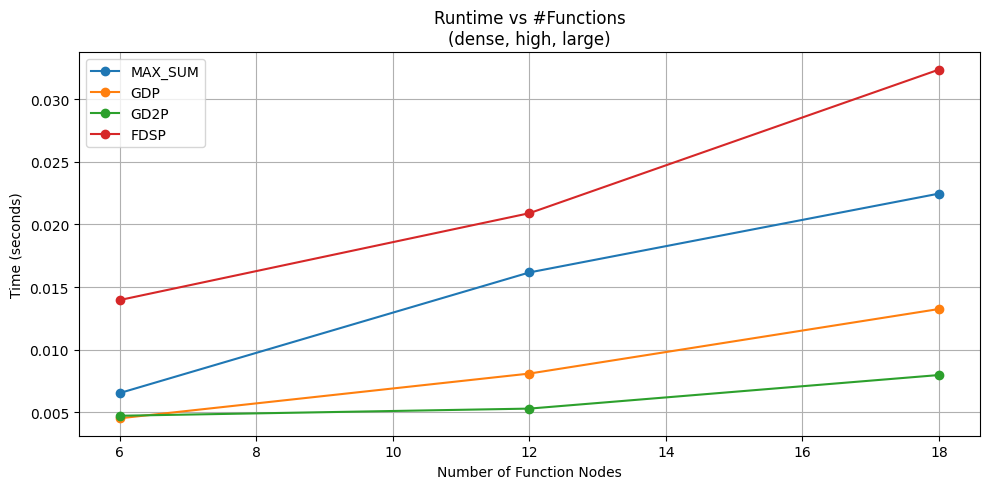

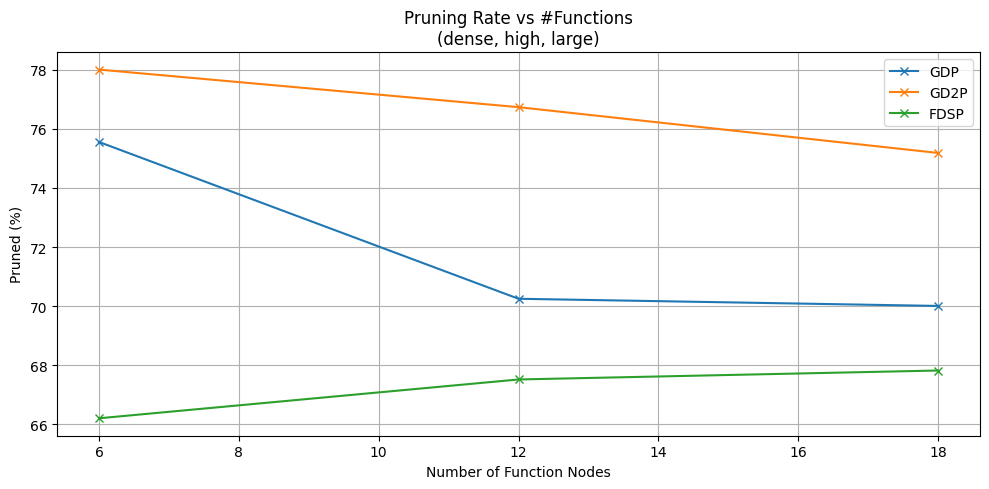

In [77]:
def run_multiple_instances(config):
    times = {'max_sum': [], 'gdp': [], 'gd2p': [], 'fdsp': []}
    prunings = {'gdp': [], 'gd2p': [], 'fdsp': []}
    func_counts = []

    for i in range(config['num_instances']):
        nfunc = config['num_functions'] * (i + 1)
        func_counts.append(nfunc)

        print(f"\n===== Running with {nfunc} functions =====")
        dcop = generate_DCOP_problem(
            graph_type=config['graph_type'],
            arity_type=config['arity_type'],
            domain_size_type=config['domain_size_type'],
            num_functions=nfunc
        )
        _, timing, pruning = run_algorithm_comparison(dcop)

        for algo in times:
            times[algo].append(timing[algo])
        for algo in prunings:
            prunings[algo].append(pruning[algo])

    return func_counts, times, prunings

def plot_summary(func_counts, times, prunings, config):
    import matplotlib.pyplot as plt

    # 1. Runtime vs #Functions
    plt.figure(figsize=(10, 5))
    for algo in times:
        plt.plot(func_counts, times[algo], marker='o', label=algo.upper())
    plt.title(f"Runtime vs #Functions\n({config['graph_type']}, {config['arity_type']}, {config['domain_size_type']})")
    plt.xlabel("Number of Function Nodes")
    plt.ylabel("Time (seconds)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{config['graph_type']}_{config['arity_type']}_{config['domain_size_type']}_runtime_vs_funcs.png")
    plt.show()

    # 2. Pruning % vs #Functions (GDP, GD2P, FDSP)
    plt.figure(figsize=(10, 5))
    for algo in prunings:
        plt.plot(func_counts, prunings[algo], marker='x', label=algo.upper())
    plt.title(f"Pruning Rate vs #Functions\n({config['graph_type']}, {config['arity_type']}, {config['domain_size_type']})")
    plt.xlabel("Number of Function Nodes")
    plt.ylabel("Pruned (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{config['graph_type']}_{config['arity_type']}_{config['domain_size_type']}_pruning_vs_funcs.png")
    plt.show()

    # Configuration remains the same
config = {
    'graph_type': 'dense',
    'arity_type': 'high',
    'domain_size_type': 'large',
    'num_functions': 6,
    'num_instances': 3
}

func_counts, times, prunings = run_multiple_instances(config)
plot_summary(func_counts, times, prunings, config)


## Algorithm Explanations

### 1. Max-Sum Algorithm
- **Basic message passing**: No pruning, considers all possible assignments
- **Complexity**: Exponential in the number of variables per factor
- **Guarantees**: Optimal solution for tree-structured graphs
- **Use case**: Small factors or when optimal solution is required

### 2. GDP (Generalized Distributive Pruning)
- **Pruning strategy**: Eliminates assignments that cannot lead to optimal solutions
- **Key insight**: Uses bounds to prune search space based on utility ranges
- **Complexity**: Reduced compared to Max-Sum, but still exponential in worst case
- **Use case**: Medium-sized factors where some pruning helps

### 3. GD2P (Generalized Distributive 2-Pruning)
- **Enhanced pruning**: More aggressive pruning using tighter bounds
- **Key insight**: Maintains lower bound during search to prune more assignments
- **Complexity**: Better pruning than GDP, significantly reduced search space
- **Use case**: Large factors where aggressive pruning is needed

### 4. FDSP (Function Decomposition and State Pruning)
- **Function decomposition**: Decomposes complex functions into manageable subproblems
- **State pruning**: Eliminates unpromising states during search using bounds
- **Key insight**: Precomputes informed and uninformed estimates for efficient bounds calculation
- **Complexity**: Most sophisticated pruning, uses recursive search with bounds
- **Implementation**: 
  - **Uninformed estimates**: Maximum utility for partial assignments
  - **Informed estimates**: Conditional maximum utility given future variable assignments
  - **Recursive search**: Branch-and-bound with upper bound pruning
- **Use case**: Complex factors with high connectivity where sophisticated decomposition and pruning is essential

## Key Observations

1. **Solution Quality**: All algorithms should converge to the same optimal solution for this problem
2. **Efficiency**: FDSP ≥ GD2P > GDP > Max-Sum (in terms of pruning effectiveness)
3. **Implementation**: Variable nodes remain the same; only function node message passing differs
4. **Convergence**: All algorithms use the same iterative message passing framework
5. **Pruning sophistication**: FDSP uses the most advanced decomposition and state pruning techniques

## Practical Applications

- **Resource allocation problems**
- **Task scheduling**
- **Sensor network optimization**
- **Multi-agent coordination**
- **Configuration problems**
- **Distributed constraint optimization**
